In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import erf
from tqdm import tqdm

In [58]:
def reading_csv(file_path):
    df = pd.read_csv(file_path)
    mean_used = df['S2_val'].tolist()
    result    = df['Decision (S1>S2)'].tolist()
    data_tuple = (result, mean_used)
    return data_tuple

def data_var2(file_path):
    df = pd.read_csv(file_path)
    var2 = df['S2_std'].to_numpy()
    var2 = pd.unique(var2)     # valeurs uniques de S2_std
    return list(var2)

def psycometrique(data_tuple, var2, block_size=200, big_blocs=11):
    """
    Reconstruit les moyennes par bloc comme dans ton code :
    - true_array_result[j][k] = P(1) pour le j-ième var2, k-ième S2_val
    - true_array_mean_used[j][k] = S2_val moyenne correspondante
    """
    result, mean_used = data_tuple
    true_array_mean_used = []
    true_array_result    = []

    size_one_block = block_size * big_blocs  # nb essais par courbe (11 x 200)

    for j in range(len(var2)):
        array_mean_result = []
        array_mean_used   = []
        for i in range(0, size_one_block, block_size):
            # bloc de result
            block_r = result[size_one_block*j + i : size_one_block*j + i + block_size]
            mean_r  = sum(block_r) / len(block_r)
            array_mean_result.append(mean_r)

            # bloc de mean_used
            block_m = mean_used[size_one_block*j + i : size_one_block*j + i + block_size]
            mean_m  = sum(block_m) / len(block_m)
            array_mean_used.append(mean_m)

        true_array_result.append(array_mean_result)
        true_array_mean_used.append(array_mean_used)

    return true_array_result, true_array_mean_used

def build_targets_from_csv(file_path, block_size=200, big_blocs=11):
    """
    Construit :
      - target[(mu2, std2)] = P_empirique(réponse=1)
      - mus_test : liste ordonnée des S2_val utilisés
      - vars_test : liste ordonnée des S2_std utilisés
    à partir de ton CSV.
    """
    data_tuple = reading_csv(file_path)
    var2_list  = data_var2(file_path)           # S2_std uniques
    array_mean_result, array_mean_used = psycometrique(
        data_tuple, var2_list,
        block_size=block_size,
        big_blocs=big_blocs
    )

    target = {}
    # on suppose que les S2_val sont les mêmes pour chaque var2
    mus_test = array_mean_used[0]
    vars_test = var2_list

    for j, std2 in enumerate(var2_list):
        for k, mu2 in enumerate(array_mean_used[j]):
            p_emp = array_mean_result[j][k]
            target[(mu2, std2)] = p_emp

    return target, mus_test, vars_test

In [59]:
target, mus_test, vars_test = build_targets_from_csv('C:\\Users\\gabri\\Desktop\\bayesian\\experiment_results_test.csv')
print(target)

{(-10.0, np.int64(0)): 1.0, (-8.0, np.int64(0)): 1.0, (-6.0, np.int64(0)): 1.0, (-4.0, np.int64(0)): 1.0, (-2.0, np.int64(0)): 1.0, (0.0, np.int64(0)): 0.53, (2.0, np.int64(0)): 0.005, (4.0, np.int64(0)): 0.0, (6.0, np.int64(0)): 0.0, (8.0, np.int64(0)): 0.0, (10.0, np.int64(0)): 0.0, (-10.0, np.int64(2)): 1.0, (-8.0, np.int64(2)): 0.995, (-6.0, np.int64(2)): 0.99, (-4.0, np.int64(2)): 0.93, (-2.0, np.int64(2)): 0.815, (0.0, np.int64(2)): 0.55, (2.0, np.int64(2)): 0.34, (4.0, np.int64(2)): 0.12, (6.0, np.int64(2)): 0.025, (8.0, np.int64(2)): 0.0, (10.0, np.int64(2)): 0.0, (-10.0, np.int64(4)): 0.95, (-8.0, np.int64(4)): 0.92, (-6.0, np.int64(4)): 0.9, (-4.0, np.int64(4)): 0.88, (-2.0, np.int64(4)): 0.77, (0.0, np.int64(4)): 0.63, (2.0, np.int64(4)): 0.575, (4.0, np.int64(4)): 0.375, (6.0, np.int64(4)): 0.37, (8.0, np.int64(4)): 0.285, (10.0, np.int64(4)): 0.155, (-10.0, np.int64(6)): 0.88, (-8.0, np.int64(6)): 0.86, (-6.0, np.int64(6)): 0.795, (-4.0, np.int64(6)): 0.825, (-2.0, np.int6

In [ ]:
mus_test  = [-10,-8,-6,-4,-2,0,2,4,6,8,10]
vars_test = [0,2,4,6,8]

def sample_dobs(mu1, std1, mu2, std2):
    A = np.random.normal(mu1, std1)
    B = np.random.normal(mu2, std2)
    return A - B

def posterior_params(dobs, std1, std2, mu0, std0):
    var_lik = std1**2 + std2**2      # v
    var0    = std0**2               # sigma0^2

    sigma_post2 = 1.0 / (1.0/var0 + 1.0/var_lik)
    mu_post     = sigma_post2 * (mu0/var0 + dobs/var_lik)
    return mu_post, np.sqrt(sigma_post2)

def Phi(z):
    # CDF normale standard avec scipy.special.erf
    return 0.5 * (1.0 + erf(z / np.sqrt(2.0)))

def prob_response_1(mu1, std1, mu2, std2, mu0, std0):
    """
    Tire un dobs, calcule le posterior, renvoie P(répondre 1) = P(x>0|dobs).
    """
    dobs = sample_dobs(mu1, std1, mu2, std2)
    mu_post, sigma_post = posterior_params(dobs, std1, std2, mu0, std0)
    return Phi(mu_post / sigma_post)

def agent_response(mu1, std1, mu2, std2, mu0, std0):
    """
    Agent stochastique : tire une Bernoulli avec proba = P(répondre 1).
    """
    p1 = prob_response_1(mu1, std1, mu2, std2, mu0, std0)
    return 1 if np.random.rand() < p1 else 0

mu1  = 0.0
std1 = 0.2
relation = 0.155

def simulate_for_std0(std0, n_trials=2000):
    """
    Fixe std0, déduit mu0 = relation * std0**2, 
    puis calcule P_modèle(1) pour chaque (mu2, std2).
    """
    var0 = std0**2
    mu0  = relation * var0
    results = {}
    for mu2 in mus_test:
        for std2 in vars_test:
            count = 0
            for _ in range(n_trials):
                count += agent_response(mu1, std1, mu2, std2, mu0, std0)
            results[(mu2, std2)] = count / n_trials
    return mu0, results

def mse_for_std0(std0, n_trials=2000):
    mu0, sim = simulate_for_std0(std0, n_trials=n_trials)
    err = 0.0
    for key, target_val in target.items():
        err += (sim[key] - target_val)**2
    return mu0, err / len(target), sim

# ========= 4) Grid search sur std0 (mu0 déduit du ratio) =========

std0_grid = np.linspace(2, 5.0, 100)   # à ajuster si besoin

best_std0 = None
best_mu0  = None
best_mse  = np.inf
best_sim  = None

mse_array = []
for std0 in std0_grid:
    mu0, mse, sim = mse_for_std0(std0, n_trials=1500)
    mse_array.append(mse)
    print(f"std0={std0:.2f}, mu0={mu0:.3f}, MSE={mse:.5f}")
    if mse < best_mse:
        best_mse = mse
        best_std0 = std0
        best_mu0  = mu0
        best_sim  = sim

print("\nBEST PARAMETERS (avec mu0/sigma0^2 = 0.15 fixé) :")
print(f"std0={best_std0:.3f}, mu0={best_mu0:.3f}, MSE={best_mse:.6f}")

# ========= 5) Plot psychométriques : données vs meilleur agent =========

plt.figure(figsize=(8,5))
colors = {
    0: "tab:purple",
    2: "tab:blue",
    4: "tab:orange",
    6: "tab:green",
    8: "tab:red"
}


for std2 in vars_test:
    xs = mus_test
    ys_model  = [best_sim[(mu2, std2)]   for mu2 in mus_test]
    ys_target = [target[(mu2, std2)]     for mu2 in mus_test]

    plt.plot(xs, ys_model,  "-o", label=f"modèle var={std2}",  color=colors[std2])
    plt.plot(xs, ys_target, "--",  alpha=0.5, color=colors[std2])

plt.axhline(0.5, linestyle="--", color="red", alpha=0.5, label="Chance (0.5)")
plt.xlabel("Mean S2 value (mu2)")
plt.ylabel("P(réponse=1)")
plt.title("Psychometric functions : données vs agent bayésien\n(mu0/sigma0^2 = 0.15 fixé)")
plt.legend()
plt.grid(True)
plt.show()


  1%|          | 1/100 [00:00<00:59,  1.66it/s]

std0=2.00, mu0=0.620, MSE=0.00307


  2%|▏         | 2/100 [00:01<01:02,  1.58it/s]

std0=2.03, mu0=0.639, MSE=0.00292


  3%|▎         | 3/100 [00:01<01:04,  1.50it/s]

std0=2.06, mu0=0.658, MSE=0.00256


  4%|▍         | 4/100 [00:02<01:03,  1.51it/s]

std0=2.09, mu0=0.678, MSE=0.00240


  5%|▌         | 5/100 [00:03<01:04,  1.48it/s]

std0=2.12, mu0=0.697, MSE=0.00246


  6%|▌         | 6/100 [00:04<01:06,  1.42it/s]

std0=2.15, mu0=0.717, MSE=0.00227


  7%|▋         | 7/100 [00:04<01:04,  1.43it/s]

std0=2.18, mu0=0.738, MSE=0.00211


  8%|▊         | 8/100 [00:08<02:19,  1.51s/it]

std0=2.21, mu0=0.758, MSE=0.00224


  9%|▉         | 9/100 [00:11<03:04,  2.02s/it]

std0=2.24, mu0=0.779, MSE=0.00213


 10%|█         | 10/100 [00:13<03:06,  2.08s/it]

std0=2.27, mu0=0.801, MSE=0.00184


 11%|█         | 11/100 [00:14<02:27,  1.66s/it]

std0=2.30, mu0=0.822, MSE=0.00182


 12%|█▏        | 12/100 [00:14<02:01,  1.38s/it]

std0=2.33, mu0=0.844, MSE=0.00182


 13%|█▎        | 13/100 [00:15<01:42,  1.18s/it]

std0=2.36, mu0=0.866, MSE=0.00156


 14%|█▍        | 14/100 [00:16<01:33,  1.09s/it]

std0=2.39, mu0=0.888, MSE=0.00175


 15%|█▌        | 15/100 [00:17<01:21,  1.04it/s]

std0=2.42, mu0=0.911, MSE=0.00173


 16%|█▌        | 16/100 [00:17<01:13,  1.14it/s]

std0=2.45, mu0=0.934, MSE=0.00157


 17%|█▋        | 17/100 [00:18<01:08,  1.22it/s]

std0=2.48, mu0=0.957, MSE=0.00152


 18%|█▊        | 18/100 [00:19<01:03,  1.29it/s]

std0=2.52, mu0=0.981, MSE=0.00157


 19%|█▉        | 19/100 [00:19<00:59,  1.35it/s]

std0=2.55, mu0=1.004, MSE=0.00136


 20%|██        | 20/100 [00:20<00:58,  1.36it/s]

std0=2.58, mu0=1.028, MSE=0.00135


 21%|██        | 21/100 [00:21<00:56,  1.39it/s]

std0=2.61, mu0=1.053, MSE=0.00112


 22%|██▏       | 22/100 [00:21<00:54,  1.44it/s]

std0=2.64, mu0=1.077, MSE=0.00136


 23%|██▎       | 23/100 [00:22<00:55,  1.39it/s]

std0=2.67, mu0=1.102, MSE=0.00116


 24%|██▍       | 24/100 [00:23<00:52,  1.44it/s]

std0=2.70, mu0=1.127, MSE=0.00116


 25%|██▌       | 25/100 [00:24<00:54,  1.37it/s]

std0=2.73, mu0=1.153, MSE=0.00139


 26%|██▌       | 26/100 [00:24<00:51,  1.42it/s]

std0=2.76, mu0=1.179, MSE=0.00116


 27%|██▋       | 27/100 [00:25<00:51,  1.42it/s]

std0=2.79, mu0=1.205, MSE=0.00112


 28%|██▊       | 28/100 [00:26<00:51,  1.39it/s]

std0=2.82, mu0=1.231, MSE=0.00118


 29%|██▉       | 29/100 [00:26<00:47,  1.48it/s]

std0=2.85, mu0=1.258, MSE=0.00097


 30%|███       | 30/100 [00:27<00:50,  1.40it/s]

std0=2.88, mu0=1.285, MSE=0.00096


 31%|███       | 31/100 [00:28<00:50,  1.37it/s]

std0=2.91, mu0=1.312, MSE=0.00090


 32%|███▏      | 32/100 [00:29<00:49,  1.38it/s]

std0=2.94, mu0=1.339, MSE=0.00081


 33%|███▎      | 33/100 [00:29<00:51,  1.30it/s]

std0=2.97, mu0=1.367, MSE=0.00095


 34%|███▍      | 34/100 [00:30<00:48,  1.35it/s]

std0=3.00, mu0=1.395, MSE=0.00093


 35%|███▌      | 35/100 [00:31<00:48,  1.35it/s]

std0=3.03, mu0=1.423, MSE=0.00082


 36%|███▌      | 36/100 [00:31<00:45,  1.39it/s]

std0=3.06, mu0=1.452, MSE=0.00083


 37%|███▋      | 37/100 [00:32<00:42,  1.48it/s]

std0=3.09, mu0=1.481, MSE=0.00084


 38%|███▊      | 38/100 [00:33<00:39,  1.56it/s]

std0=3.12, mu0=1.510, MSE=0.00072


 39%|███▉      | 39/100 [00:33<00:37,  1.62it/s]

std0=3.15, mu0=1.539, MSE=0.00082


 40%|████      | 40/100 [00:34<00:36,  1.67it/s]

std0=3.18, mu0=1.569, MSE=0.00076


 41%|████      | 41/100 [00:34<00:34,  1.70it/s]

std0=3.21, mu0=1.599, MSE=0.00076


 42%|████▏     | 42/100 [00:35<00:34,  1.70it/s]

std0=3.24, mu0=1.630, MSE=0.00081


 43%|████▎     | 43/100 [00:35<00:32,  1.73it/s]

std0=3.27, mu0=1.660, MSE=0.00077


 44%|████▍     | 44/100 [00:36<00:33,  1.68it/s]

std0=3.30, mu0=1.691, MSE=0.00069


 45%|████▌     | 45/100 [00:37<00:34,  1.60it/s]

std0=3.33, mu0=1.722, MSE=0.00083


 46%|████▌     | 46/100 [00:38<00:36,  1.46it/s]

std0=3.36, mu0=1.754, MSE=0.00091


 47%|████▋     | 47/100 [00:38<00:35,  1.49it/s]

std0=3.39, mu0=1.785, MSE=0.00065


 48%|████▊     | 48/100 [00:39<00:34,  1.49it/s]

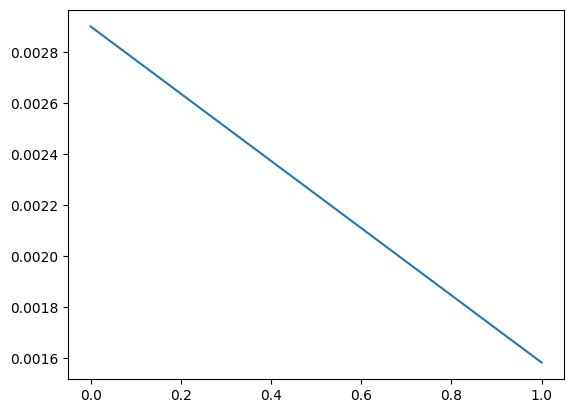

In [ ]:
plt.plot(mse_array)